In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats.mstats import winsorize
from linearmodels import PanelOLS
import seaborn as sns
import statsmodels.api as sm1
import statsmodels.formula.api as sm
from linearmodels.panel import compare
from collections import OrderedDict
import statsmodels.tools as tools
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Question 1

In [2]:
#import data

dataset = pd.read_csv("firm-data-fg2009.csv", index_col = ['datadate'], parse_dates = ['datadate'])
dataset.index.names = ['Date']

dataset

,gvkey,company_name,sic_code,fiscal_year,fiscal_year_end,debt_in_cur_liab,lt_debt,share_price,shares_outstanding,preferred_liq_val,def_tax_inv_credit,total_assets,property_plant_eq,oper_inc_before_depr,dividend_payer
Date,,,,,,,,,,,,,,,
1951-04-30,1010,ACF INDUSTRIES INC,3743,1950,4,16.000,9.200,34.0000,0.599,28.9,0.000,145.100,60.400,9.920,True
1950-12-31,1040,AMF INC,3949,1950,12,0.000,0.000,14.1250,1.121,7.8,0.000,30.300,4.900,3.630,True
1950-07-31,1043,MULTIGRAPHICS INC,5040,1950,7,0.300,2.500,51.0000,0.754,0.0,0.000,34.400,7.200,9.490,True
1950-12-31,1045,AMERICAN AIRLINES GROUP INC,4512,1950,12,0.000,30.000,13.7500,6.453,40.0,0.000,136.700,85.300,34.440,True
1950-12-31,1078,ABBOTT LABORATORIES,3845,1950,12,2.500,0.000,44.8750,3.740,0.0,0.000,77.600,17.400,20.100,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,330227,CASTOR MARITIME INC,4412,2020,12,7.102,11.083,0.1850,131.212,0.0,0.000,74.371,58.046,2.202,False
2020-12-31,331856,IMMUNIC INC,2836,2020,12,0.000,0.679,15.2900,21.168,0.0,0.000,167.861,1.104,-48.932,False
2020-12-31,332115,ARMATA PHARMACEUTICALS INC,2836,2020,12,2.273,10.877,2.9849,18.688,0.0,3.077,39.516,12.837,-20.473,False


### Question 1.1

In [3]:
Dataframe1 = dataset 
Dataframe1['Date'] = Dataframe1.index
# Variables used in the Core Model of Leverage((Table V in Frank and Goyal (2009),)):

#1)Median industry leverage (IndustLev): Median of total debt to market value of assets by SIC code and by year. 
# MVA is obtained as the sum of the market value of equity (price-close × sharesoutstanding) +  short-term debt +  long-term debt + preferred-liquidation mvalue − deferred taxes and investment tax credit.
Dataframe1['mva'] = (dataset['share_price'] * dataset['shares_outstanding']) + dataset['debt_in_cur_liab'] +dataset['lt_debt']+ dataset['preferred_liq_val'] - dataset['def_tax_inv_credit'] 
Dataframe1['Totaldebt_to_market'] = (dataset['debt_in_cur_liab'] +dataset['lt_debt']) / dataset['mva']
Dataframe1['Totaldebt_to_asset'] = (dataset['debt_in_cur_liab'] +dataset['lt_debt']) / dataset['total_assets']
#Data frame with only 3 columns  ('sic_code','fiscal_year','TDM') for computing Industlev:
industry=Dataframe1.copy()
#industry= industry[['sic_code','fiscal_year','Totaldebt_to_market']].groupby(['fiscal_year','sic_code']).median()
industry= industry[['sic_code','fiscal_year','Totaldebt_to_market']]
industry=industry.rename(columns={ "Totaldebt_to_market": "IndustLev"})
industry=industry.groupby(['fiscal_year','sic_code']).median()
#industry = industry.reset_index() #inorder to be able to merge 

#2)Tangibility (Tang): Ratio of net property, plant, and equipment to item assets.
Dataframe1['Tang'] = dataset['property_plant_eq'] / dataset['total_assets']
#3)Market-to-book ratio (Mktbk): Ratio of MVA to assets. 
Dataframe1['Mktbk'] = Dataframe1['mva'] / dataset['total_assets']
#4)Ratio of operating income before depreciation to assets
Dataframe1['Profit'] = dataset['oper_inc_before_depr'] / dataset['total_assets']
#5)Log of assets (Assets) is the log of assets
Dataframe1['Asset'] = np.log(dataset['total_assets'])
#6)NOT INFLATION 




In [4]:
#Merge the two dataframes
Dataframe2 = Dataframe1.merge(industry, on=['fiscal_year','sic_code'])

#Make a copy of gvkey and use it as an index, so the ratios have a reference point
Dataframe2['gvkey_index'] = Dataframe2['gvkey']
Dataframe2 = Dataframe2.set_index('gvkey_index')

Dataframe2

,gvkey,company_name,sic_code,fiscal_year,fiscal_year_end,debt_in_cur_liab,lt_debt,share_price,shares_outstanding,preferred_liq_val,...,dividend_payer,Date,mva,Totaldebt_to_market,Totaldebt_to_asset,Tang,Mktbk,Profit,Asset,IndustLev
gvkey_index,,,,,,,,,,,,,,,,,,,,,
1010,1010,ACF INDUSTRIES INC,3743,1950,4,16.000,9.200,34.0000,0.599,28.9,...,True,1951-04-30,74.466000,0.338409,0.173673,0.416265,0.513205,0.068367,4.977423,0.169205
10017,10017,STANRAY CORP,3743,1950,12,0.000,0.000,16.1250,1.385,0.0,...,True,1950-12-31,22.333125,0.000000,0.000000,0.281250,1.395820,0.300625,2.772589,0.169205
1040,1040,AMF INC,3949,1950,12,0.000,0.000,14.1250,1.121,7.8,...,True,1950-12-31,23.634125,0.000000,0.000000,0.161716,0.780004,0.119802,3.411148,0.000000
1043,1043,MULTIGRAPHICS INC,5040,1950,7,0.300,2.500,51.0000,0.754,0.0,...,True,1950-07-31,41.254000,0.067872,0.081395,0.209302,1.199244,0.275872,3.538057,0.067872
1045,1045,AMERICAN AIRLINES GROUP INC,4512,1950,12,0.000,30.000,13.7500,6.453,40.0,...,True,1950-12-31,158.728750,0.189002,0.219459,0.623994,1.161147,0.251939,4.917789,0.279758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163118,163118,WARNER MUSIC GROUP CORP,3652,2020,9,39.000,3403.000,37.9900,510.028,0.0,...,True,2020-09-30,22654.963720,0.151931,0.536973,0.094228,3.534316,0.028081,8.765615,0.151931
164755,164755,CROCS INC,3021,2020,12,47.064,326.401,62.6600,65.856,0.0,...,False,2020-12-31,4500.001960,0.082992,0.333832,0.201022,4.022445,0.235786,7.019943,0.082992
170758,170758,CAESARSTONE LTD,3281,2020,12,33.722,133.425,12.8900,34.437,0.0,...,True,2020-12-31,604.096930,0.276689,0.203609,0.422466,0.735877,0.072140,6.710427,0.276689


In [5]:
#Drop unnecessary columns and transpose to make it more readable
Dataframe3=Dataframe2.copy()
Dataframe3=Dataframe3[['IndustLev','Tang','Mktbk','Profit','Asset']].T
Dataframe3

gvkey_index,1010,10017,1040,1043,1045,2367,3452,3851,4183,7672,...,155941,176471,189594,160681,161843,163118,164755,170758,183831,345920
IndustLev,0.169205,0.169205,0.000000,0.067872,0.279758,0.279758,0.279758,0.279758,0.279758,0.279758,...,0.408243,0.408243,0.408243,0.303608,0.303608,0.151931,0.082992,0.276689,0.645399,0.011259
Tang,0.416265,0.281250,0.161716,0.209302,0.623994,0.458333,0.382979,0.548387,0.378092,0.681223,...,0.059076,0.087925,0.036591,0.221404,0.131288,0.094228,0.201022,0.422466,0.100271,0.080774
Mktbk,0.513205,1.395820,0.780004,1.199244,1.161147,1.092014,0.623670,1.045363,0.931484,0.829449,...,0.745590,0.976839,2.463677,0.726183,0.877429,3.534316,4.022445,0.735877,0.850296,6.459461
Profit,0.068367,0.300625,0.119802,0.275872,0.251939,0.236111,0.180851,0.211290,0.289753,0.144541,...,0.141343,0.135945,-0.040260,0.052272,0.020496,0.028081,0.235786,0.072140,-0.156504,0.043221
Asset,4.977423,2.772589,3.411148,3.538057,4.917789,2.667228,1.547563,2.517696,4.036009,3.824284,...,3.865665,3.786596,7.964371,7.528063,5.156725,8.765615,7.019943,6.710427,0.389336,5.619658


### Question 1.2

In [6]:
#Drop the Unnecessary Columns:
Dataframe4=Dataframe2.copy()
Dataframe4.drop(columns = {'fiscal_year_end',
       'debt_in_cur_liab', 'lt_debt', 'share_price', 'shares_outstanding',
       'preferred_liq_val', 'def_tax_inv_credit', 'total_assets',
       'property_plant_eq', 'oper_inc_before_depr', 'dividend_payer'}, inplace = True)

#Drop the Nans :
Dataframe4=Dataframe4.dropna()

#We should sort inorder to be able to shift base on gvkey
Dataframe4 = Dataframe4.sort_values(['gvkey','fiscal_year'])

Dataframe4['lag_IndsLev']=np.where(Dataframe4['gvkey'].shift(1) == Dataframe4['gvkey'], Dataframe4['IndustLev'].shift(1), np.nan)
Dataframe4['lag_Tang']=np.where(Dataframe4['gvkey'].shift(1) == Dataframe4['gvkey'], Dataframe4['Tang'].shift(1), np.nan)
Dataframe4['lag_Mktbk']=np.where(Dataframe4['gvkey'].shift(1) == Dataframe4['gvkey'], Dataframe4['Mktbk'].shift(1), np.nan)
Dataframe4['lag_Profit']=np.where(Dataframe4['gvkey'].shift(1) == Dataframe4['gvkey'], Dataframe4['Profit'].shift(1), np.nan)
Dataframe4['lag_Asset']=np.where(Dataframe4['gvkey'].shift(1) == Dataframe4['gvkey'], Dataframe4['Asset'].shift(1), np.nan)

#Drop nans again
Dataframe4.dropna(inplace=True)
Dataframe4


,gvkey,company_name,sic_code,fiscal_year,Date,mva,Totaldebt_to_market,Totaldebt_to_asset,Tang,Mktbk,Profit,Asset,IndustLev,lag_IndsLev,lag_Tang,lag_Mktbk,lag_Profit,lag_Asset
gvkey_index,,,,,,,,,,,,,,,,,,
1000,1000,A & E PLASTIK PAK INC,3089,1970,1970-12-31,37.755000,0.352139,0.397459,0.265351,1.128700,0.161016,3.510052,0.352139,0.126793,0.397599,2.112288,0.089689,0.347836
1000,1000,A & E PLASTIK PAK INC,3089,1971,1971-12-31,30.396250,0.433442,0.449199,0.260450,1.036354,0.085646,3.378611,0.235822,0.352139,0.265351,1.128700,0.161016,3.510052
1000,1000,A & E PLASTIK PAK INC,3089,1972,1972-12-31,21.584750,0.324303,0.351635,0.352288,1.084279,0.206410,2.991071,0.206264,0.235822,0.260450,1.036354,0.085646,3.378611
1000,1000,A & E PLASTIK PAK INC,3089,1973,1973-12-31,11.739000,0.596303,0.321529,0.340269,0.539204,0.207340,3.080579,0.463255,0.206264,0.352288,1.084279,0.206410,2.991071
1000,1000,A & E PLASTIK PAK INC,3089,1974,1974-12-31,12.391750,0.605241,0.292535,0.221975,0.483335,0.188002,3.244076,0.588373,0.463255,0.340269,0.539204,0.207340,3.080579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328795,328795,ARCOSA INC,3440,2019,2019-12-31,2211.665000,0.057106,0.054853,0.361260,0.960549,0.104539,7.741751,0.216021,0.219999,0.369671,0.679359,0.085858,7.683496
328795,328795,ARCOSA INC,3440,2020,2020-12-31,2810.626000,0.098092,0.104167,0.351834,1.061936,0.107190,7.881069,0.201509,0.216021,0.361260,0.960549,0.104539,7.741751
330227,330227,CASTOR MARITIME INC,4412,2020,2020-12-31,42.459220,0.428293,0.244517,0.780492,0.570911,0.029608,4.309066,0.712262,0.602674,0.779067,0.719743,0.060485,3.415133


### Question 1.3

18.881355443808307

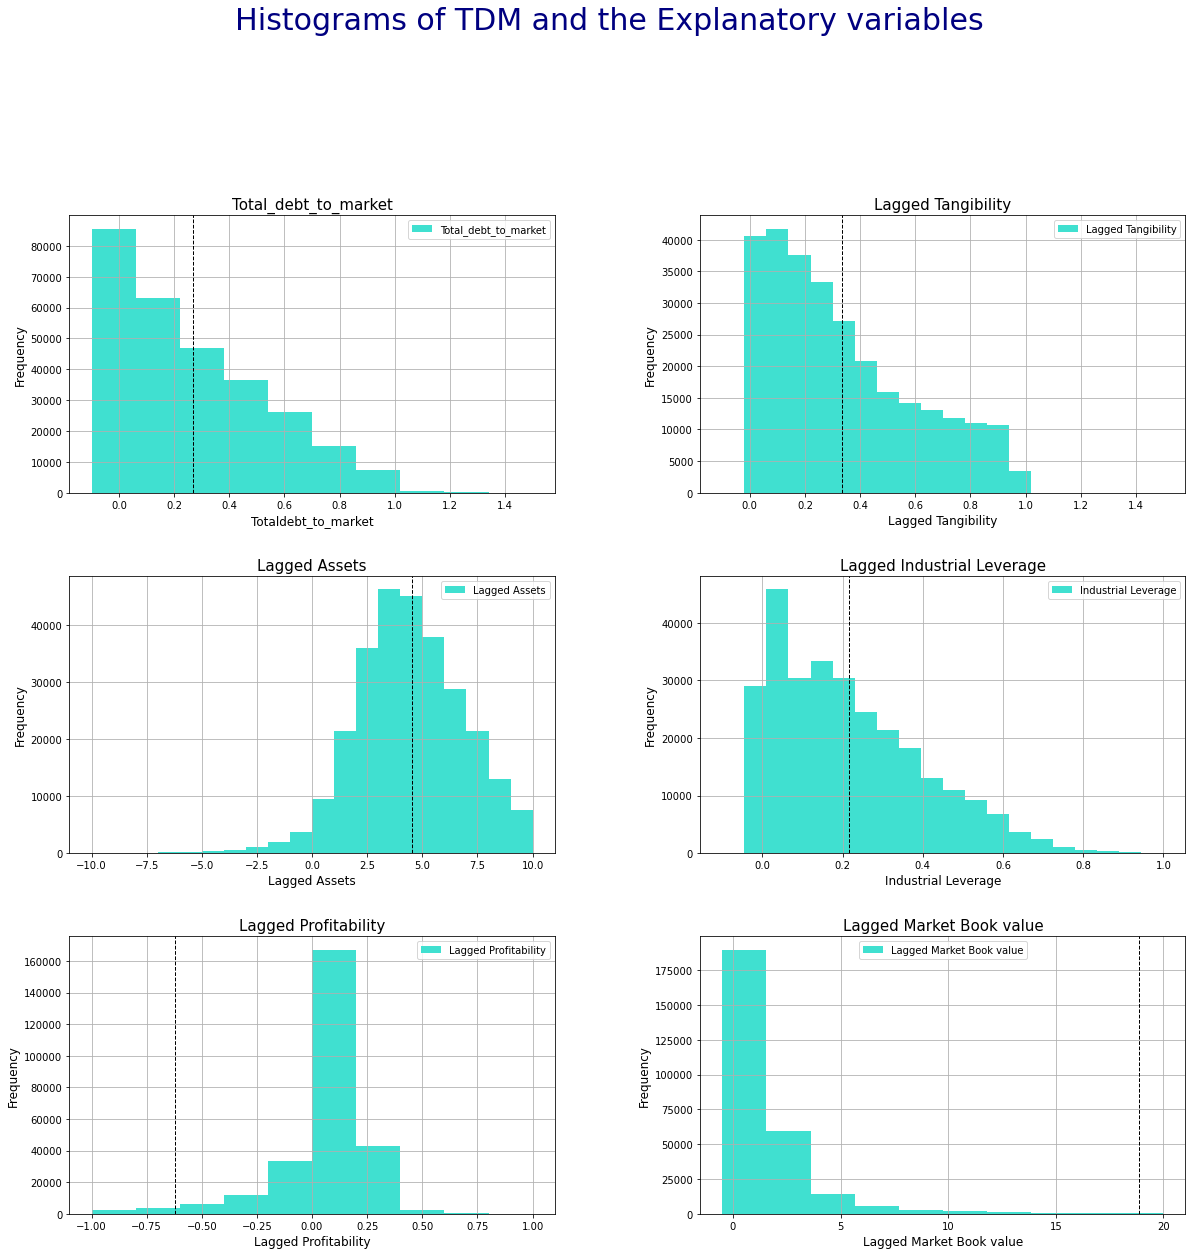

In [7]:
figure=plt.figure(figsize=(20 , 25))
plt.suptitle('Histograms of TDM and the Explanatory variables',fontsize=30, color = 'navy',va='bottom')

#Totaldebt_to_market
figure1 = figure.add_subplot(4,2,1)
Dataframe4['Totaldebt_to_market'].hist(range=[-0.1,1.5], bins=10, label='Total_debt_to_market',color='turquoise')

plt.legend()
figure1.title.set_text('Total_debt_to_market')
figure1.title.set_size(15)
figure1.set_xlabel('Totaldebt_to_market',fontsize=12)
figure1.set_ylabel('Frequency',fontsize=12)
plt.axvline(Dataframe4['Totaldebt_to_market'].mean(), color='k', linestyle='dashed', linewidth=1)

#Lagged Tangibility
figure2 = figure.add_subplot(4,2,2)
Dataframe4['lag_Tang'].hist(range=[-0.1,1.5], bins=20, label='Lagged Tangibility',color='turquoise')
plt.legend()
figure2.title.set_text('Lagged Tangibility')
figure2.title.set_size(15)
figure2.set_xlabel('Lagged Tangibility',fontsize=12)
figure2.set_ylabel('Frequency',fontsize=12)
plt.axvline(Dataframe4['lag_Tang'].mean(), color='k', linestyle='dashed', linewidth=1)

#Lagged Assets
figure3 = figure.add_subplot(4,2,3)
Dataframe4['lag_Asset'].hist(range=[-10, 10], bins=20, label='Lagged Assets',color='turquoise')

plt.legend()
figure3.title.set_text('Lagged Assets')
figure3.title.set_size(15)
figure3.set_xlabel('Lagged Assets',fontsize=12)
figure3.set_ylabel('Frequency',fontsize=12)
plt.axvline(Dataframe4['lag_Asset'].mean(), color='k', linestyle='dashed', linewidth=1)


#Industrial Leverage
figure4 = figure.add_subplot(4,2,4)
Dataframe4['lag_IndsLev'].hist(range=[-0.1,1], bins=20, label='Industrial Leverage',color='turquoise')

plt.legend()
figure4.title.set_text('Lagged Industrial Leverage')
figure4.title.set_size(15)
figure4.set_xlabel('Industrial Leverage',fontsize=12)
figure4.set_ylabel('Frequency',fontsize=12)
plt.axvline(Dataframe4['lag_IndsLev'].mean(), color='k', linestyle='dashed', linewidth=1)

#Lagged Profitability
figure5 = figure.add_subplot(4,2,5)
Dataframe4['lag_Profit'].hist(range=[-1,1], bins=10, label='Lagged Profitability',color='turquoise')

plt.legend()
figure5.title.set_text('Lagged Profitability')
figure5.title.set_size(15)
figure5.set_xlabel('Lagged Profitability',fontsize=12)
figure5.set_ylabel('Frequency',fontsize=12)
plt.axvline(Dataframe4['lag_Profit'].mean(), color='k', linestyle='dashed', linewidth=1)

#Lagged Market Book value
figure6 = figure.add_subplot(4,2,6)
Dataframe4['lag_Mktbk'].hist(range=[-0.5, 20], bins=10, label='Lagged Market Book value',color='turquoise')

plt.legend()
figure6.title.set_text('Lagged Market Book value')
figure6.title.set_size(15)
figure6.set_xlabel('Lagged Market Book value',fontsize=12)
figure6.set_ylabel('Frequency',fontsize=12)

plt.subplots_adjust(wspace= 0.3, hspace= 0.3)
#dist.plot.hist(density=True, ax=ax)
#sns.distplot(Dataframe4['lag_Mktbk'], fit=stats.laplace, kde=False)
plt.axvline(Dataframe4['lag_Mktbk'].mean(), color='k', linestyle='dashed', linewidth=1)
Dataframe4['lag_Mktbk'].mean()


***What can you say about their distributions? Do you find anything unexpected?***

Distributions: 
We made 6 histograms for the 5 lagged explanatory variables and TDM. For a clearer understanding of the plotted data, we gave them different range and bin to be able to capture the most important feature of each individual graph. 

We observe that Lagged Assets and Lagged Profitability have approximately a normal distribution regarding their bell-shaped distributions. Additionally, Lagged Assets has a mean nearly directly in the middle of its bell curve, indicating it is mostly, normally distributed.

TDM, Lagged Tangibility and Lagged Industrial Leverage have right skewed distributions which means that the data set's lower bounds are extremely low relative to the rest of the data. However, Lagged Market Book value has left skewed distributions showing the inverse.

The means for both Lagged Profitability and Lagged Market to Book Value are both well away from where the majority of their observations are clustered, indicating large outliers in the dataset.

Unexpected: 

As previously stated, only Lagged Profitability and Lagged Market to Book Value have means well outside of their distributions. This is unexpected as the rest of the indicators seem to have means indicative of their distributions, regardless of skew. This could indicate that the majority of large outliers within the dataset, lie in profitability of firms and market to book value of their shares. 

For profitability, this could mean that some businesses are so grossly unprofitable, that they pull the mean downwards. For Market to Book Value, this could mean that some companies are so grossly overvalued, compared to their book value, that they are pulling the mean in a positive direction.




### Question 1.4

In [8]:
#Create a copy of the Dataframe
Winsorize = Dataframe4.copy()
#Create new columns with the winsorized Data for unlagged variables
Winsorize['win_mva'] = winsorize(Winsorize['mva'], limits = .005)
Winsorize['win_Totaldebt_to_market'] = winsorize(Winsorize['Totaldebt_to_market'], limits = .005)
Winsorize['win_Totaldebt_to_asset'] = winsorize(Winsorize['Totaldebt_to_asset'], limits = .005)
Winsorize['win_ Tang'] = winsorize(Winsorize['Tang'], limits = .005)
Winsorize['win_Mktbk'] = winsorize(Winsorize['Mktbk'], limits = .005)
Winsorize['win_Profit'] = winsorize(Winsorize['Profit'], limits = .005)
Winsorize['win_IndustLev'] = winsorize(Winsorize['IndustLev'], limits = .005)

Winsorize

,gvkey,company_name,sic_code,fiscal_year,Date,mva,Totaldebt_to_market,Totaldebt_to_asset,Tang,Mktbk,...,lag_Mktbk,lag_Profit,lag_Asset,win_mva,win_Totaldebt_to_market,win_Totaldebt_to_asset,win_ Tang,win_Mktbk,win_Profit,win_IndustLev
gvkey_index,,,,,,,,,,,,,,,,,,,,,
1000,1000,A & E PLASTIK PAK INC,3089,1970,1970-12-31,37.755000,0.352139,0.397459,0.265351,1.128700,...,2.112288,0.089689,0.347836,37.755000,0.352139,0.397459,0.265351,1.128700,0.161016,0.352139
1000,1000,A & E PLASTIK PAK INC,3089,1971,1971-12-31,30.396250,0.433442,0.449199,0.260450,1.036354,...,1.128700,0.161016,3.510052,30.396250,0.433442,0.449199,0.260450,1.036354,0.085646,0.235822
1000,1000,A & E PLASTIK PAK INC,3089,1972,1972-12-31,21.584750,0.324303,0.351635,0.352288,1.084279,...,1.036354,0.085646,3.378611,21.584750,0.324303,0.351635,0.352288,1.084279,0.206410,0.206264
1000,1000,A & E PLASTIK PAK INC,3089,1973,1973-12-31,11.739000,0.596303,0.321529,0.340269,0.539204,...,1.084279,0.206410,2.991071,11.739000,0.596303,0.321529,0.340269,0.539204,0.207340,0.463255
1000,1000,A & E PLASTIK PAK INC,3089,1974,1974-12-31,12.391750,0.605241,0.292535,0.221975,0.483335,...,0.539204,0.207340,3.080579,12.391750,0.605241,0.292535,0.221975,0.483335,0.188002,0.588373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328795,328795,ARCOSA INC,3440,2019,2019-12-31,2211.665000,0.057106,0.054853,0.361260,0.960549,...,0.679359,0.085858,7.683496,2211.665000,0.057106,0.054853,0.361260,0.960549,0.104539,0.216021
328795,328795,ARCOSA INC,3440,2020,2020-12-31,2810.626000,0.098092,0.104167,0.351834,1.061936,...,0.960549,0.104539,7.741751,2810.626000,0.098092,0.104167,0.351834,1.061936,0.107190,0.201509
330227,330227,CASTOR MARITIME INC,4412,2020,2020-12-31,42.459220,0.428293,0.244517,0.780492,0.570911,...,0.719743,0.060485,3.415133,42.459220,0.428293,0.244517,0.780492,0.570911,0.029608,0.712262


In [9]:
#Create columns with winsorized data for lagged variables
Winsorize['win_lag_Mktbk'] = winsorize(Winsorize['lag_Mktbk'], limits = .005)
Winsorize['win_lag_IndsLev'] = winsorize(Winsorize['lag_IndsLev'], limits = .005)
Winsorize['win_lag_Tang'] = winsorize(Winsorize['lag_Tang'], limits = .005)
Winsorize['win_lag_Profit'] = winsorize(Winsorize['lag_Profit'], limits = .005)

Winsorize

,gvkey,company_name,sic_code,fiscal_year,Date,mva,Totaldebt_to_market,Totaldebt_to_asset,Tang,Mktbk,...,win_Totaldebt_to_market,win_Totaldebt_to_asset,win_ Tang,win_Mktbk,win_Profit,win_IndustLev,win_lag_Mktbk,win_lag_IndsLev,win_lag_Tang,win_lag_Profit
gvkey_index,,,,,,,,,,,,,,,,,,,,,
1000,1000,A & E PLASTIK PAK INC,3089,1970,1970-12-31,37.755000,0.352139,0.397459,0.265351,1.128700,...,0.352139,0.397459,0.265351,1.128700,0.161016,0.352139,2.112288,0.126793,0.397599,0.089689
1000,1000,A & E PLASTIK PAK INC,3089,1971,1971-12-31,30.396250,0.433442,0.449199,0.260450,1.036354,...,0.433442,0.449199,0.260450,1.036354,0.085646,0.235822,1.128700,0.352139,0.265351,0.161016
1000,1000,A & E PLASTIK PAK INC,3089,1972,1972-12-31,21.584750,0.324303,0.351635,0.352288,1.084279,...,0.324303,0.351635,0.352288,1.084279,0.206410,0.206264,1.036354,0.235822,0.260450,0.085646
1000,1000,A & E PLASTIK PAK INC,3089,1973,1973-12-31,11.739000,0.596303,0.321529,0.340269,0.539204,...,0.596303,0.321529,0.340269,0.539204,0.207340,0.463255,1.084279,0.206264,0.352288,0.206410
1000,1000,A & E PLASTIK PAK INC,3089,1974,1974-12-31,12.391750,0.605241,0.292535,0.221975,0.483335,...,0.605241,0.292535,0.221975,0.483335,0.188002,0.588373,0.539204,0.463255,0.340269,0.207340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328795,328795,ARCOSA INC,3440,2019,2019-12-31,2211.665000,0.057106,0.054853,0.361260,0.960549,...,0.057106,0.054853,0.361260,0.960549,0.104539,0.216021,0.679359,0.219999,0.369671,0.085858
328795,328795,ARCOSA INC,3440,2020,2020-12-31,2810.626000,0.098092,0.104167,0.351834,1.061936,...,0.098092,0.104167,0.351834,1.061936,0.107190,0.201509,0.960549,0.216021,0.361260,0.104539
330227,330227,CASTOR MARITIME INC,4412,2020,2020-12-31,42.459220,0.428293,0.244517,0.780492,0.570911,...,0.428293,0.244517,0.780492,0.570911,0.029608,0.712262,0.719743,0.602674,0.779067,0.060485


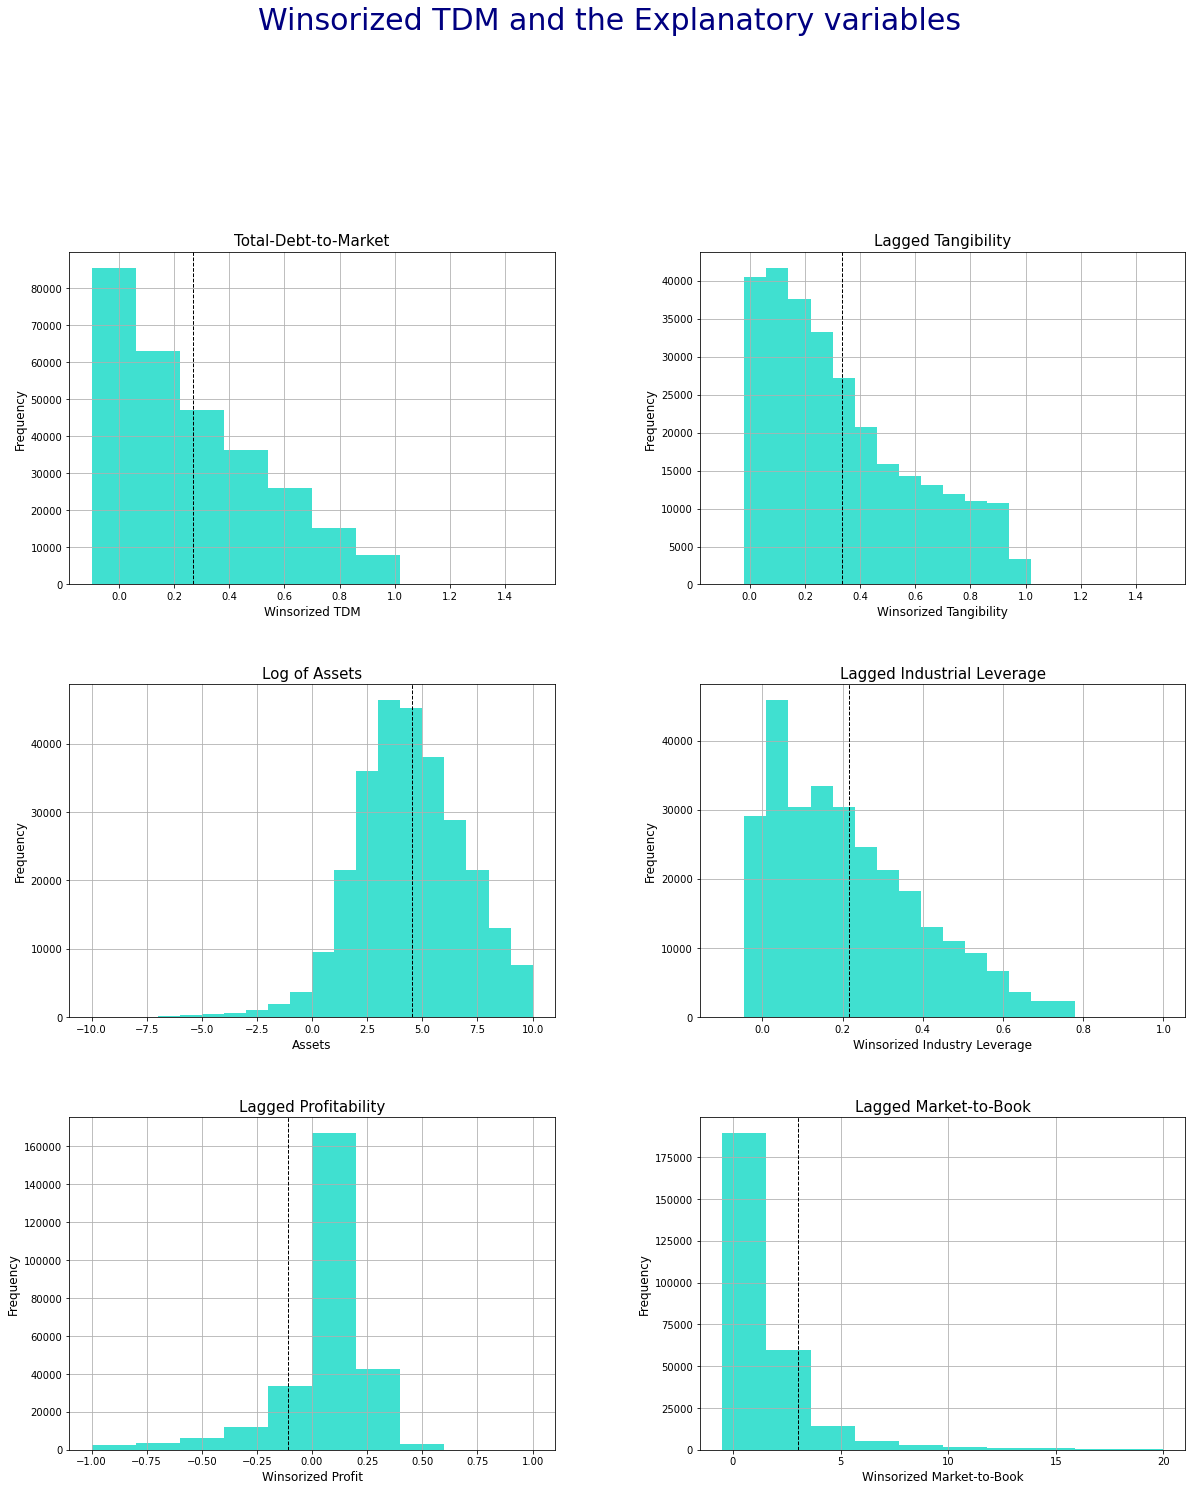

In [10]:
#Plot Winsorized TDM and the Winsorized explanitory variables
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.suptitle('Winsorized TDM and the Explanatory variables',fontsize=30, color = 'navy',va='bottom')
#Winsorized TDM subplot
TDM = fig.add_subplot(4,2,1)
Winsorize['win_Totaldebt_to_market'].hist(range=[-0.1,1.5],bins = 10,color='turquoise')
plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Winsorized TDM',fontsize=12)
TDM.title.set_text('Total-Debt-to-Market')
plt.axvline(Winsorize['win_Totaldebt_to_market'].mean(), color='k', linestyle='dashed', linewidth=1)
TDM.title.set_size(15)


#Winzorized lagged tangibility subplot
tang = fig.add_subplot(4,2,2)
Winsorize['win_lag_Tang'].hist(bins = 20,range=[-0.1,1.5],color='turquoise')
plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Winsorized Tangibility',fontsize=12)
tang.title.set_text('Lagged Tangibility')
plt.axvline(Winsorize['win_lag_Tang'].mean(), color='k', linestyle='dashed', linewidth=1)
tang.title.set_size(15)


#Winsorized lagged Log of Assets subplot
ass = fig.add_subplot(4,2,3)
Winsorize['lag_Asset'].hist(bins = 20,range=[-10, 10],color='turquoise')
plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Assets',fontsize=12)
ass.title.set_text('Log of Assets')
plt.axvline(Winsorize['lag_Asset'].mean(), color='k', linestyle='dashed', linewidth=1)
ass.title.set_size(15)

#Winzorized lagged Industrial Leverage subplot
indlev = fig.add_subplot(4,2,4)
Winsorize['win_lag_IndsLev'].hist(bins = 20,range=[-0.1,1],color='turquoise')
plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Winsorized Industry Leverage',fontsize=12)
indlev.title.set_text('Lagged Industrial Leverage')
plt.axvline(Winsorize['win_lag_IndsLev'].mean(), color='k', linestyle='dashed', linewidth=1)
indlev.title.set_size(15)

#Winzorized lagged Profitability subplot
prof = fig.add_subplot(4,2,5)
Winsorize['win_lag_Profit'].hist(bins = 10, range = [-1,1],color='turquoise')
plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Winsorized Profit',fontsize=12)
prof.title.set_text('Lagged Profitability')
plt.axvline(Winsorize['win_lag_Profit'].mean(), color='k', linestyle='dashed', linewidth=1)
prof.title.set_size(15)

#Winsorized lagged Market to Book subplot
mtb = fig.add_subplot(4,2,6)
Winsorize['win_lag_Mktbk'].hist(bins = 10, range = [-0.5, 20],color='turquoise')
plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Winsorized Market-to-Book',fontsize=12)
mtb.title.set_text('Lagged Market-to-Book')
plt.axvline(Winsorize['win_lag_Mktbk'].mean(), color='k', linestyle='dashed', linewidth=1)
mtb.title.set_size(15)




***Explain what effect winsorization should have on the estimates of a linear regression model.***

Winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. And if we have some of these spurious outliers after the winsorization we can expect more robust estimates. 
In our Data the we can see that in first 4 graphs we are witnessing slight difference to before and after winsorization. However, Lagged Market-to-book ratio has the highest changes. it means changed from 18 to approximately 3 which shows that there were some extreme right hand side outliers in the data. 
 

# Question 2

## Question 2.1

In [11]:
# We make a function that calculates descriptive statics
def dscriptive_statistics(df_column):
    a= len(df_column) # a is count
    b= round(df_column.mean(),2) # b is mean
    c= round(df_column.std(),2) # c is standard deviation
    d= df_column.quantile(0.10).round(2) # d is 10th percentile
    e= df_column.quantile(0.50).round(2) # e is 50th percentile
    f= df_column.quantile(0.90).round(2) # f is 90th percentile
    data = np.array([a,b,c,d,e,f])
    my_series= pd.DataFrame(data, index=['N','Mean','SD','10th','50th','90th'])
    my_series= my_series.T
    return my_series

In [12]:
# Calculating descriptive statics below
TDM_DS= dscriptive_statistics(Winsorize['Totaldebt_to_market'])
L_ASSETS_DS= dscriptive_statistics(Winsorize['Asset'])
L_MRKBTY_DS= dscriptive_statistics(Winsorize['win_lag_Mktbk'])
L_PROFIT_DS= dscriptive_statistics(Winsorize['win_lag_Profit'])
L_IND_LEV_DS= dscriptive_statistics(Winsorize['win_lag_IndsLev'])
L_TANG_DS= dscriptive_statistics(Winsorize['win_lag_Tang'])

# We merge descriptive ststistics of all variables
dataframe_DS= pd.concat([TDM_DS, L_MRKBTY_DS, L_PROFIT_DS, L_ASSETS_DS, L_IND_LEV_DS, L_TANG_DS], axis=0)
dataframe_DS['Variable']= ['TDM','Mktbk','Profit','Assets','IndustLev','Tangibility']
dataframe_DS= dataframe_DS.set_index('Variable')
print("Data Description for companies in our data:")
display(dataframe_DS)

Data Description for companies in our data:


,N,Mean,SD,10th,50th,90th
Variable,,,,,,
TDM,281401.0,0.27,0.31,0.00,0.20,0.66
Mktbk,281401.0,3.03,11.50,0.53,1.08,4.01
Profit,281401.0,-0.11,1.21,-0.30,0.11,0.23
Assets,281401.0,4.63,2.57,1.63,4.51,7.98
IndustLev,281401.0,0.22,0.18,0.01,0.18,0.48
Tangibility,281401.0,0.33,0.26,0.04,0.27,0.76


## Question 2.2

In [13]:
# Below we consider values for years untill 2003
before= Winsorize.loc[(Winsorize["fiscal_year"] <= 2003)]

# Calculating descriptive statics below
TDM_DS_before= dscriptive_statistics(before['Totaldebt_to_market'])
L_ASSETS_DS_before= dscriptive_statistics(before['Asset'])
L_MRKBTY_DS_before= dscriptive_statistics(before['win_lag_Mktbk'])
L_PROFIT_DS_before= dscriptive_statistics(before['win_lag_Profit'])
L_IND_LEV_DS_before= dscriptive_statistics(before['win_lag_IndsLev'])
L_TANG_DS_before= dscriptive_statistics(before['win_lag_Tang'])

# We merge descriptive ststistics of all variables
dataframe_DS_before= pd.concat([TDM_DS_before, L_MRKBTY_DS_before, L_PROFIT_DS_before, L_ASSETS_DS_before, L_IND_LEV_DS_before, L_TANG_DS_before], axis=0)
dataframe_DS_before['Variable']= ['TDM','Mktbk','Profit','Assets','IndustLev','Tangibility']
dataframe_DS_before= dataframe_DS_before.set_index('Variable')
print("Data Description for companies in our data - before (and including) 2003:")
display(dataframe_DS_before)

Data Description for companies in our data - before (and including) 2003:


,N,Mean,SD,10th,50th,90th
Variable,,,,,,
TDM,187525.0,0.29,0.30,0.00,0.24,0.68
Mktbk,187525.0,1.99,6.27,0.51,0.99,3.21
Profit,187525.0,0.03,0.68,-0.13,0.12,0.25
Assets,187525.0,4.36,2.21,1.73,4.23,7.30
IndustLev,187525.0,0.25,0.18,0.03,0.22,0.51
Tangibility,187525.0,0.35,0.25,0.07,0.30,0.75


In [14]:
after= Winsorize.loc[(Winsorize["fiscal_year"] > 2003)]
# Calculating descriptive statics below
TDM_DS_after= dscriptive_statistics(after['Totaldebt_to_market'])
L_ASSETS_DS_after= dscriptive_statistics(after['Asset'])
L_MRKBTY_DS_after= dscriptive_statistics(after['win_lag_Mktbk'])
L_PROFIT_DS_after= dscriptive_statistics(after['win_lag_Profit'])
L_IND_LEV_DS_after= dscriptive_statistics(after['win_lag_IndsLev'])
L_TANG_DS_after= dscriptive_statistics(after['win_lag_Tang'])


# We merge descriptive ststistics of all variables
dataframe_DS_after= pd.concat([TDM_DS_after, L_MRKBTY_DS_after, L_PROFIT_DS_after, L_ASSETS_DS_after, L_IND_LEV_DS_after, L_TANG_DS_after], axis=0)
dataframe_DS_after['Variable']= ['TDM','Mktbk','Profit','Assets','IndustLev','Tangibility']
dataframe_DS_after= dataframe_DS_after.set_index('Variable')
print("Data Description for companies in our data - after 2003:")
display(dataframe_DS_after)

Data Description for companies in our data - after 2003:


,N,Mean,SD,10th,50th,90th
Variable,,,,,,
TDM,93876.0,0.22,0.33,0.00,0.12,0.61
Mktbk,93876.0,5.11,17.65,0.57,1.32,6.04
Profit,93876.0,-0.38,1.84,-0.74,0.07,0.20
Assets,93876.0,5.17,3.11,1.26,5.36,9.00
IndustLev,93876.0,0.15,0.16,0.00,0.10,0.39
Tangibility,93876.0,0.30,0.29,0.01,0.19,0.78


In [15]:
display(dataframe_DS_before)

,N,Mean,SD,10th,50th,90th
Variable,,,,,,
TDM,187525.0,0.29,0.30,0.00,0.24,0.68
Mktbk,187525.0,1.99,6.27,0.51,0.99,3.21
Profit,187525.0,0.03,0.68,-0.13,0.12,0.25
Assets,187525.0,4.36,2.21,1.73,4.23,7.30
IndustLev,187525.0,0.25,0.18,0.03,0.22,0.51
Tangibility,187525.0,0.35,0.25,0.07,0.30,0.75


### Question 2.3

***Compare table (a) to Table I in Frank and Goyal (2009). Are there any significant differences? Explain or speculate why.***

- The mean value of TDM, profitability, industrial leverage and tangibility is similar to the values in Table I of Frank and Goyal. However, mean value of market to book ratio and assets change slightly. Mean of market to book ratio and assets in our dataset is higher and lower respectively than values in Table I of Frank and Goyal. 
- 

reduced by ~ 6-9% from ‘before 2003‘ to  ‘after 2003’. Decrease in TDM shows that many firms moved from debt financing their assets to equity financing.
Mean of market to book ratio and assets

You can see that even though we didn't have the same exact values as Table 1 in Frank & Goyal(2009) we sure did have the same descriptive statistics. We can clearly see some changes in our variables from the Core Model of Leverage. 
Well, foremost notice a decrease in TDM of approximately 8% which is significant. We also see a much higher market to book ratio with a high standard deviation also that can be interpreted as overvaluation. And the biggest change is perhaps the Profitability ratio that became negative after 2003, these ratios indicate how efficiently a company generates profit and value for shareholders but even before 2003 it was also not that high with an average of 0.03. This can due to several effects, one of which the economic meltdown between 2007 and 2008 during the financial crisis, but we have to keep in mind that it's better to compare this ratio to each firm and industry specifically, otherwise it can be misleading. 

***Compare of table (b) to table (a). Are there any significant differences? Explain or speculate why.***


# **Question 3**

### Question 3.1 

#### For Total Debt to Market

In [16]:
#Running the first base regression
ratios_regression = Winsorize.copy()
ratios_regression=ratios_regression.reset_index().set_index(['Date', 'gvkey_index'])

x =sm1.add_constant(ratios_regression[['lag_Asset', 'win_lag_Tang', 'win_lag_Mktbk', 'win_lag_Profit','win_lag_IndsLev']])
y = ratios_regression.win_Totaldebt_to_market


OLS1 = PanelOLS(y,x).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS1.summary


Dep. Variable:,win_Totaldebt_to_market,R-squared:,0.2844
Estimator:,PanelOLS,R-squared (Between):,0.6712
No. Observations:,281401,R-squared (Within):,0.2488
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.2844
Time:,13:30:44,Log-likelihood,2.755e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.236e+04
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,281395)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,1330.6


In [17]:
#With the time effect 

ratios_regression3 = Winsorize.copy()
ratios_regression3 = ratios_regression3.reset_index()
ratios_regression3 = ratios_regression3.set_index(['Date', 'gvkey'])

y1 = ratios_regression3.Totaldebt_to_market
x1 = tools.add_constant(ratios_regression3[['lag_Asset', 'win_lag_Tang', 'win_lag_Mktbk', 'win_lag_Profit','win_lag_IndsLev']])

OLS2 = PanelOLS(y1, x1, time_effects = True).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)

OLS2.summary

Dep. Variable:,Totaldebt_to_market,R-squared:,0.0603
Estimator:,PanelOLS,R-squared (Between):,0.4839
No. Observations:,281401,R-squared (Within):,0.1437
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.1649
Time:,13:30:49,Log-likelihood,1.636e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3301.7
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,257257)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,413.33


In [18]:
#With the time and firm effect

OLS3 = PanelOLS(y1, x1,time_effects=True,entity_effects=True).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS3.summary



Dep. Variable:,Totaldebt_to_market,R-squared:,0.0378
Estimator:,PanelOLS,R-squared (Between):,0.4361
No. Observations:,281401,R-squared (Within):,0.1394
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.1584
Time:,13:33:30,Log-likelihood,1.981e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2013.8
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,256418)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,478.54


In [19]:
compare(OrderedDict([("Base OLS", OLS1), ("With Time Fixed Effect", OLS2), ("With Entity and Time Fixed Effects", OLS3)]), stars = True)


,Base OLS,With Time Fixed Effect,With Entity and Time Fixed Effects
Dep. Variable,win_Totaldebt_to_market,Totaldebt_to_market,Totaldebt_to_market
Estimator,PanelOLS,PanelOLS,PanelOLS
No. Observations,281401,281401,281401
Cov. Est.,Clustered,Clustered,Clustered
R-squared,0.2844,0.0603,0.0378
R-Squared (Within),0.2488,0.1437,0.1394
R-Squared (Between),0.6712,0.4839,0.4361
R-Squared (Overall),0.2844,0.1649,0.1584
F-statistic,2.236e+04,3301.7,2013.8
P-value (F-stat),0.0000,0.0000,0.0000


***Does adding time and firm effects substantially change the estimated values of the parameters? Comment on the economic magnitude of the changes.***

#### **With Respect to TDM**

All the coefficients except constant are considered significant from their high t-statistics before and after adding time and entity fixed effects. However, there are some observable changes on the estimated values and their T-statistic after the addition of time and fixed effects. 

##### ***For Time Fixed Effects***

After adding time fixed effects (a dummy variable for capturing the effect of time, which will change coefficients and errors) 

**The consequences will be as follow:**
1) The sign of the coefficient for the constant changes from positive to negative.
2) The T-statistic of constant reduced to less than 2 which shows the low reliability of the predictive power of this coefficient.
3) The changes in betas of the lagged industrial leverage (by 0.2096) is the largest decrease, which also decreased the T statistic as well. 
4) Decreases in lagged tangibility and lagged asset is observable and slight decrease in other independent variables; however, no major changes occurred on the t-statistics. 


##### ***For Time and Firm Fixed Effects***

After including firm fixed effects as well as time fixed effects, we were be able to control for clustering inside each firm (and capture the effect of time as well) 

**The consequences will be as follow:**
1) Minor changes in T-statistics (the largest change is again for lagged industry level which is approximately 12.03)
2) No major effect on the sign of the coefficients or their magnitude.
3) The T-statistic of constant reduced even more (it reached approximately (-0.6604)), which shows that the predictive power of this coefficient becoming less reliable.


#### For Total Debt To Asset

In [20]:
ratios_regression = Winsorize.copy()
ratios_regression=ratios_regression.reset_index().set_index(['Date', 'gvkey_index'])

x_TDA =sm1.add_constant(ratios_regression[['lag_Asset', 'win_lag_Tang', 'win_lag_Mktbk', 'win_lag_Profit','win_lag_IndsLev']])
y_TDA = ratios_regression.win_Totaldebt_to_asset


OLS1_TDA = PanelOLS(y_TDA,x_TDA).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS1_TDA.summary

Dep. Variable:,win_Totaldebt_to_asset,R-squared:,0.2483
Estimator:,PanelOLS,R-squared (Between):,0.7396
No. Observations:,281401,R-squared (Within):,0.2418
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.2483
Time:,13:33:37,Log-likelihood,-3.225e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.859e+04
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,281395)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,306.62


In [21]:
#Running TDA regression with time effects
OLS2_TDA = PanelOLS(y_TDA,x_TDA, time_effects = True).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS2_TDA.summary

Dep. Variable:,win_Totaldebt_to_asset,R-squared:,0.0745
Estimator:,PanelOLS,R-squared (Between):,0.5507
No. Observations:,281401,R-squared (Within):,0.2018
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.2063
Time:,13:33:42,Log-likelihood,-2.528e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,4141.8
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,257257)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,95.437


In [22]:
#Running TDA regression with time effects and firm effects
OLS3_TDA = PanelOLS(y_TDA,x_TDA, time_effects = True, entity_effects= True).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS3_TDA.summary

Dep. Variable:,win_Totaldebt_to_asset,R-squared:,0.0786
Estimator:,PanelOLS,R-squared (Between):,0.3090
No. Observations:,281401,R-squared (Within):,0.1980
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.1953
Time:,13:36:13,Log-likelihood,-2.507e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,4375.3
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,256418)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,102.13


In [23]:
compare(OrderedDict([("Base OLS", OLS1_TDA), ("With Time Fixed Effect", OLS2_TDA), ("With Entity and Time Fixed Effects", OLS3_TDA)]), stars = True)


,Base OLS,With Time Fixed Effect,With Entity and Time Fixed Effects
Dep. Variable,win_Totaldebt_to_asset,win_Totaldebt_to_asset,win_Totaldebt_to_asset
Estimator,PanelOLS,PanelOLS,PanelOLS
No. Observations,281401,281401,281401
Cov. Est.,Clustered,Clustered,Clustered
R-squared,0.2483,0.0745,0.0786
R-Squared (Within),0.2418,0.2018,0.1980
R-Squared (Between),0.7396,0.5507,0.3090
R-Squared (Overall),0.2483,0.2063,0.1953
F-statistic,1.859e+04,4141.8,4375.3
P-value (F-stat),0.0000,0.0000,0.0000


***Does adding time and firm effects substantially change the estimated values of the parameters? Comment on the economic magnitude of the changes.***

#### **With Respect to TDA**

***To avoid restaiting what was previously stated for TDM, only observations unique to TDA  are mentioned***

While there is variation in the T-Stat, it seems to be more constant then what was observed when TDM was the dependent variable.

##### ***For Time Fixed Effects***

**After adding time fixed effects:**

1) The T-Stat decreased for all variables
2) All T-Stats are strong predictors, as they are all above 2 or below -2
3) All coefficients are predicted at the 99% confidence interval, as indicated by the 3 stars next to the relative betas.

##### ***For Time and Firm Fixed Effects***

**After including firm fixed effects as well as time fixed effects:**

1) All T-Statistics, except for Profit and Market to book, increase
2) Similarly, all betas observed are at the 99% confidence interval

### Question 3.2

#### For Total Debt to Market

In [24]:
# Rerun the same ols model, but adding industry fixed effects instead of firm fixed effects
y1 = ratios_regression3.Totaldebt_to_market
x1 = tools.add_constant(ratios_regression3[['lag_Asset', 'win_lag_Tang', 'win_lag_Mktbk', 'win_lag_Profit','win_lag_IndsLev']])

#Create a variable for firm effects to compare
OLS3_1 = PanelOLS(y1, x1, entity_effects = True).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS3_1.summary


#Create a variable for industry effects by selecting the sic code
industry_effects = ratios_regression3['sic_code']
OLS4 = PanelOLS(y1, x1,other_effects = industry_effects).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS4.summary

Dep. Variable:,Totaldebt_to_market,R-squared:,0.0752
Estimator:,PanelOLS,R-squared (Between):,0.6346
No. Observations:,281401,R-squared (Within):,0.1669
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.1946
Time:,13:36:38,Log-likelihood,-4.064e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,4568.7
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,280987)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,542.00


In [25]:
#Compare the industry effects with the firm effects ols

compare(OrderedDict([("With Firm Fixed Effect", OLS3_1), ("With Industry Fixed Effects", OLS4)]), stars = True)


,With Firm Fixed Effect,With Industry Fixed Effects
Dep. Variable,Totaldebt_to_market,Totaldebt_to_market
Estimator,PanelOLS,PanelOLS
No. Observations,281401,281401
Cov. Est.,Clustered,Clustered
R-squared,0.1690,0.0752
R-Squared (Within),0.1690,0.1669
R-Squared (Between),0.6545,0.6346
R-Squared (Overall),0.1972,0.1946
F-statistic,1.141e+04,4568.7
P-value (F-stat),0.0000,0.0000


#### For Total Debt to Asset

In [26]:
# Rerun the same ols model, but adding industry fixed effects instead of firm fixed effects
y1 = ratios_regression3.Totaldebt_to_asset
x1 = tools.add_constant(ratios_regression3[['lag_Asset', 'win_lag_Tang', 'win_lag_Mktbk', 'win_lag_Profit','win_lag_IndsLev']])

#Create a variable for firm effects to compare
OLS3_1_TDA = PanelOLS(y1, x1, entity_effects = True).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS3_1_TDA.summary


#Create a variable for industry effects by selecting the sic code
industry_effects = ratios_regression3['sic_code']
OLS4_TDA = PanelOLS(y1, x1,other_effects = industry_effects).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS4_TDA.summary

Dep. Variable:,Totaldebt_to_asset,R-squared:,0.0235
Estimator:,PanelOLS,R-squared (Between):,0.1657
No. Observations:,281401,R-squared (Within):,0.0235
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.0239
Time:,13:36:58,Log-likelihood,-1.445e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,1354.4
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,280987)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,12.653


In [27]:
#Compare the industry effects with the firm effects ols

compare(OrderedDict([("With Firm Fixed Effect", OLS3_1_TDA), ("With Industry Fixed Effects", OLS4_TDA)]), stars = True)

,With Firm Fixed Effect,With Industry Fixed Effects
Dep. Variable,Totaldebt_to_asset,Totaldebt_to_asset
Estimator,PanelOLS,PanelOLS
No. Observations,281401,281401
Cov. Est.,Clustered,Clustered
R-squared,0.0235,0.0235
R-Squared (Within),0.0235,0.0235
R-Squared (Between),0.1638,0.1657
R-Squared (Overall),0.0239,0.0239
F-statistic,1352.9,1354.4
P-value (F-stat),0.0000,0.0000


***Is it a good idea to add industry fixed effects instead of firm fixed effects? Why
(not)?***

For the Dataset, firm fix effects appear to be more relevant. It was helpful to make the comparison and we witnessed that the sign of factors did not change in these two different ways of clustering. However, The R square and F statistic are much stronger in entity fix effect which is why we prefer to use it instead of industry fix effect. This hints at more autocorrelation within firms then between firms within the same industry. 

That being said, both the R-Squared and F-Statistic are relatively the same. This could indicate a commonality within firms and between firms of the same industry, when it comes to total debt to assets. The autocorrelation, or lack their of, is pretty well consistant and negliable for this dependent variable.

As previously stated, the autocorrelation effect was much greater for TDM. For this reason, clustering on firm, rather than industry, seems preferential in this regression model.

### Question 3.3

#### For Total Debt to Market

In [28]:
# Rerun the same ols model, but clustered by industry fixed effects instead of firm fixed effects with the time fixed effects
ratios_regression = Winsorize.copy()
ratios_regression=ratios_regression.reset_index().set_index(['Date', 'gvkey_index'])

x =sm1.add_constant(ratios_regression[['lag_Asset', 'win_lag_Tang', 'win_lag_Mktbk', 'win_lag_Profit','win_lag_IndsLev']])
y = ratios_regression.win_Totaldebt_to_market

OLS5 = PanelOLS(y1, x1).fit(cov_type = 'clustered', cluster_time = True, cluster_other = industry_effects)
OLS5.summary

Dep. Variable:,Totaldebt_to_asset,R-squared:,0.0239
Estimator:,PanelOLS,R-squared (Between):,0.1743
No. Observations:,281401,R-squared (Within):,0.0235
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.0239
Time:,13:37:09,Log-likelihood,-1.446e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,1380.3
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,281395)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,13.332


In [29]:
# compare the ols regressions for time and firm fixed effects with 
compare(OrderedDict([("Clustered by Time and Firm - TDM", OLS1), ('Clustered by Time and Industry - TDM', OLS5)]), stars = True)


,Clustered by Time and Firm - TDM,Clustered by Time and Industry - TDM
Dep. Variable,win_Totaldebt_to_market,Totaldebt_to_asset
Estimator,PanelOLS,PanelOLS
No. Observations,281401,281401
Cov. Est.,Clustered,Clustered
R-squared,0.2844,0.0239
R-Squared (Within),0.2488,0.0235
R-Squared (Between),0.6712,0.1743
R-Squared (Overall),0.2844,0.0239
F-statistic,2.236e+04,1380.3
P-value (F-stat),0.0000,0.0000


**Total Debt to Market**

***What happens to the t-statistics? Do any conclusions about the significance of the factors change?***


1)All T-Statistics decreased significantly, with Assets and Tangebility have T-Statistics below 2.

2)For the constant, assets and tangebility, the significance of factors change. All of them were previously at a 99% confidence interval, but clusturing by industry weakened the predictiveness of the resulting betas.

#### For Total debt to Asset

In [30]:
# Rerun the same ols model, but clustered by industry fixed effects instead of firm fixed effects with the time fixed effects
ratios_regression = Winsorize.copy()
ratios_regression=ratios_regression.reset_index().set_index(['Date', 'gvkey_index'])

x =sm1.add_constant(ratios_regression[['lag_Asset', 'win_lag_Tang', 'win_lag_Mktbk', 'win_lag_Profit','win_lag_IndsLev']])
y = ratios_regression.win_Totaldebt_to_asset

OLS5_TDA = PanelOLS(y1, x1).fit(cov_type = 'clustered', cluster_time = True, cluster_other = industry_effects)
OLS5_TDA.summary

Dep. Variable:,Totaldebt_to_asset,R-squared:,0.0239
Estimator:,PanelOLS,R-squared (Between):,0.1743
No. Observations:,281401,R-squared (Within):,0.0235
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.0239
Time:,13:37:12,Log-likelihood,-1.446e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,1380.3
Entities:,840,P-value,0.0000
Avg Obs:,335.00,Distribution:,"F(5,281395)"
Min Obs:,3.0000,,
Max Obs:,4474.0,F-statistic (robust):,13.332


In [31]:
compare(OrderedDict([("Clustered by Time and Firm - TDA", OLS1_TDA), ('Clustered by Time and Industry - TDA', OLS5_TDA)]), stars = True)


,Clustered by Time and Firm - TDA,Clustered by Time and Industry - TDA
Dep. Variable,win_Totaldebt_to_asset,Totaldebt_to_asset
Estimator,PanelOLS,PanelOLS
No. Observations,281401,281401
Cov. Est.,Clustered,Clustered
R-squared,0.2483,0.0239
R-Squared (Within),0.2418,0.0235
R-Squared (Between),0.7396,0.1743
R-Squared (Overall),0.2483,0.0239
F-statistic,1.859e+04,1380.3
P-value (F-stat),0.0000,0.0000


**Total Debt to Asset**

***What happens to the t-statistics? Do any conclusions about the significance of the factors change?***

1) Similarly, all T-Statistics saw the same results as with TDM. In this case, it seems that clusturing on industry affects both TDM and TDA in the same manner, making both results less relevant.
2) Again, the constant, Assets and tangebility all saw a decrease in the predictive strength of their resulting betas.

### Question 3.4

In [32]:
#Import new Dataset
Q3_dataset = pd.read_csv("Q3_Data.csv", index_col = ['datadate'], parse_dates = ['datadate'])
Q3_dataset.index.names = ['Date']

Q3_dataset

,gvkey,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,cshoq,dlcq,dlttq,pstkq,txditcq,costat,prccq
Date,,,,,,,,,,,,,,,,,
1966-03-31,1000,1966,1.0,INDL,C,D,STD,USD,1966Q1,1966Q1,0.219,NaN,NaN,NaN,NaN,I,NaN
1966-06-30,1000,1966,2.0,INDL,C,D,STD,USD,1966Q2,1966Q2,0.219,NaN,NaN,NaN,NaN,I,NaN
1966-09-30,1000,1966,3.0,INDL,C,D,STD,USD,1966Q3,1966Q3,0.219,NaN,NaN,NaN,NaN,I,NaN
1966-12-31,1000,1966,4.0,INDL,C,D,STD,USD,1966Q4,1966Q4,0.219,NaN,NaN,NaN,NaN,I,NaN
1967-03-31,1000,1967,1.0,INDL,C,D,STD,USD,1967Q1,1967Q1,0.277,NaN,NaN,NaN,NaN,I,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,351590,2020,2.0,INDL,C,D,STD,USD,2020Q2,2020Q2,NaN,NaN,NaN,NaN,NaN,A,NaN
2020-09-30,351590,2020,3.0,INDL,C,D,STD,USD,2020Q3,2020Q3,NaN,NaN,NaN,NaN,NaN,A,NaN
2020-12-31,351590,2020,4.0,INDL,C,D,STD,USD,2020Q4,2020Q4,NaN,14229.582,10539.895,0.0,119.333,A,NaN


In [33]:
#Select only relevant companies

companies = dataset['gvkey'].unique()

Q3_dataset = Q3_dataset.loc[Q3_dataset['gvkey'].isin(companies)]

Q3_dataset

,gvkey,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,cshoq,dlcq,dlttq,pstkq,txditcq,costat,prccq
Date,,,,,,,,,,,,,,,,,
1966-03-31,1000,1966,1.0,INDL,C,D,STD,USD,1966Q1,1966Q1,0.219,NaN,NaN,NaN,NaN,I,NaN
1966-06-30,1000,1966,2.0,INDL,C,D,STD,USD,1966Q2,1966Q2,0.219,NaN,NaN,NaN,NaN,I,NaN
1966-09-30,1000,1966,3.0,INDL,C,D,STD,USD,1966Q3,1966Q3,0.219,NaN,NaN,NaN,NaN,I,NaN
1966-12-31,1000,1966,4.0,INDL,C,D,STD,USD,1966Q4,1966Q4,0.219,NaN,NaN,NaN,NaN,I,NaN
1967-03-31,1000,1967,1.0,INDL,C,D,STD,USD,1967Q1,1967Q1,0.277,NaN,NaN,NaN,NaN,I,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31,345920,2020,1.0,INDL,C,D,STD,USD,2020Q1,2020Q1,NaN,NaN,NaN,NaN,NaN,A,NaN
2020-06-30,345920,2020,2.0,INDL,C,D,STD,USD,2020Q2,2020Q2,NaN,NaN,NaN,NaN,NaN,A,NaN
2020-09-30,345920,2020,3.0,INDL,C,D,STD,USD,2020Q3,2020Q3,31.647,40.366,87.952,27.584,0.0,A,NaN


In [34]:
# Calculate MVA

Q3_dataset['MVA'] = Q3_dataset['cshoq']*Q3_dataset['prccq'] + Q3_dataset['dlcq'] + Q3_dataset['dlttq'] + Q3_dataset['pstkq'] - Q3_dataset['txditcq']
Q3_dataset

,gvkey,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,cshoq,dlcq,dlttq,pstkq,txditcq,costat,prccq,MVA
Date,,,,,,,,,,,,,,,,,,
1966-03-31,1000,1966,1.0,INDL,C,D,STD,USD,1966Q1,1966Q1,0.219,NaN,NaN,NaN,NaN,I,NaN,NaN
1966-06-30,1000,1966,2.0,INDL,C,D,STD,USD,1966Q2,1966Q2,0.219,NaN,NaN,NaN,NaN,I,NaN,NaN
1966-09-30,1000,1966,3.0,INDL,C,D,STD,USD,1966Q3,1966Q3,0.219,NaN,NaN,NaN,NaN,I,NaN,NaN
1966-12-31,1000,1966,4.0,INDL,C,D,STD,USD,1966Q4,1966Q4,0.219,NaN,NaN,NaN,NaN,I,NaN,NaN
1967-03-31,1000,1967,1.0,INDL,C,D,STD,USD,1967Q1,1967Q1,0.277,NaN,NaN,NaN,NaN,I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31,345920,2020,1.0,INDL,C,D,STD,USD,2020Q1,2020Q1,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN
2020-06-30,345920,2020,2.0,INDL,C,D,STD,USD,2020Q2,2020Q2,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN
2020-09-30,345920,2020,3.0,INDL,C,D,STD,USD,2020Q3,2020Q3,31.647,40.366,87.952,27.584,0.0,A,NaN,NaN


In [35]:
#Find the percentage change from the previous quarter

#Make a lag variable
Q3_dataset['MVA_lag'] = np.where(Q3_dataset['gvkey'].shift(1) == Q3_dataset['gvkey'], Q3_dataset['MVA'].shift(1), np.nan)

#Calculate percentage change
Q3_dataset['MVA_change(1)'] = np.where(Q3_dataset['gvkey'].shift(1) == Q3_dataset['gvkey'], (Q3_dataset['MVA'] - Q3_dataset['MVA_lag'])/Q3_dataset['MVA_lag'], np.nan)

Q3_dataset

,gvkey,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,cshoq,dlcq,dlttq,pstkq,txditcq,costat,prccq,MVA,MVA_lag,MVA_change(1)
Date,,,,,,,,,,,,,,,,,,,,
1966-03-31,1000,1966,1.0,INDL,C,D,STD,USD,1966Q1,1966Q1,0.219,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN
1966-06-30,1000,1966,2.0,INDL,C,D,STD,USD,1966Q2,1966Q2,0.219,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN
1966-09-30,1000,1966,3.0,INDL,C,D,STD,USD,1966Q3,1966Q3,0.219,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN
1966-12-31,1000,1966,4.0,INDL,C,D,STD,USD,1966Q4,1966Q4,0.219,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN
1967-03-31,1000,1967,1.0,INDL,C,D,STD,USD,1967Q1,1967Q1,0.277,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31,345920,2020,1.0,INDL,C,D,STD,USD,2020Q1,2020Q1,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN
2020-06-30,345920,2020,2.0,INDL,C,D,STD,USD,2020Q2,2020Q2,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN
2020-09-30,345920,2020,3.0,INDL,C,D,STD,USD,2020Q3,2020Q3,31.647,40.366,87.952,27.584,0.0,A,NaN,NaN,NaN,NaN


In [36]:
Q4_dataset = Q3_dataset.copy()

In [37]:
Q4_dataset_1 = Q3_dataset.copy()
Q4_dataset_1['MVA_Volatility'] = Q4_dataset_1.groupby(['gvkey'])['MVA_change(1)'].transform(lambda x: x.rolling(window = 8, min_periods = 5).std())
Q4_dataset_1

,gvkey,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,...,dlcq,dlttq,pstkq,txditcq,costat,prccq,MVA,MVA_lag,MVA_change(1),MVA_Volatility
Date,,,,,,,,,,,,,,,,,,,,,
1966-03-31,1000,1966,1.0,INDL,C,D,STD,USD,1966Q1,1966Q1,...,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN,NaN
1966-06-30,1000,1966,2.0,INDL,C,D,STD,USD,1966Q2,1966Q2,...,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN,NaN
1966-09-30,1000,1966,3.0,INDL,C,D,STD,USD,1966Q3,1966Q3,...,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN,NaN
1966-12-31,1000,1966,4.0,INDL,C,D,STD,USD,1966Q4,1966Q4,...,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN,NaN
1967-03-31,1000,1967,1.0,INDL,C,D,STD,USD,1967Q1,1967Q1,...,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31,345920,2020,1.0,INDL,C,D,STD,USD,2020Q1,2020Q1,...,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN
2020-06-30,345920,2020,2.0,INDL,C,D,STD,USD,2020Q2,2020Q2,...,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN
2020-09-30,345920,2020,3.0,INDL,C,D,STD,USD,2020Q3,2020Q3,...,40.366,87.952,27.584,0.0,A,NaN,NaN,NaN,NaN,NaN


In [38]:
Q4_dataset_1.dropna(inplace = True)
Q4_dataset_1

,gvkey,fyearq,fqtr,indfmt,consol,popsrc,datafmt,curcdq,datacqtr,datafqtr,...,dlcq,dlttq,pstkq,txditcq,costat,prccq,MVA,MVA_lag,MVA_change(1),MVA_Volatility
Date,,,,,,,,,,,,,,,,,,,,,
1976-03-31,1000,1976,1.0,INDL,C,D,STD,USD,1976Q1,1976Q1,...,1.674,10.114,2.069,1.183,I,6.7500,26.822000,16.310750,0.644437,0.273781
1976-06-30,1000,1976,2.0,INDL,C,D,STD,USD,1976Q2,1976Q2,...,1.257,10.513,2.069,1.185,I,7.2500,28.335750,26.822000,0.056437,0.250852
1976-09-30,1000,1976,3.0,INDL,C,D,STD,USD,1976Q3,1976Q3,...,1.507,10.347,2.069,1.185,I,7.1250,28.213500,28.335750,-0.004314,0.238028
1976-12-31,1000,1976,4.0,INDL,C,D,STD,USD,1976Q4,1976Q4,...,0.350,13.583,1.569,1.421,I,5.7500,26.771250,28.213500,-0.051119,0.230809
1977-03-31,1000,1977,1.0,INDL,C,D,STD,USD,1977Q1,1977Q1,...,0.350,15.350,1.569,1.421,I,6.2500,29.654250,26.771250,0.107690,0.230152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,330227,2020,4.0,INDL,C,D,STD,USD,2020Q4,2020Q4,...,7.102,11.083,0.000,0.000,A,0.1850,42.459220,38.926769,0.090746,0.355885
2021-03-31,330227,2021,1.0,INDL,C,D,STD,USD,2021Q1,2021Q1,...,8.878,23.734,0.000,0.000,A,0.7610,570.830011,42.459220,12.444194,4.317877
2020-09-30,332115,2020,3.0,INDL,C,D,STD,USD,2020Q3,2020Q3,...,2.126,10.909,0.000,3.077,A,3.1900,69.512110,82.661640,-0.159077,0.425181


In [39]:
#Make a copy of the original dataframe
og_df = Winsorize.copy()
og_df = og_df.set_index(['gvkey', 'fiscal_year'])
og_df

company_name  sic_code       Date  \
gvkey  fiscal_year                                                    
1000   1970              A & E PLASTIK PAK INC      3089 1970-12-31   
       1971              A & E PLASTIK PAK INC      3089 1971-12-31   
       1972              A & E PLASTIK PAK INC      3089 1972-12-31   
       1973              A & E PLASTIK PAK INC      3089 1973-12-31   
       1974              A & E PLASTIK PAK INC      3089 1974-12-31   
...                                        ...       ...        ...   
328795 2019                         ARCOSA INC      3440 2019-12-31   
       2020                         ARCOSA INC      3440 2020-12-31   
330227 2020                CASTOR MARITIME INC      4412 2020-12-31   
331856 2020                        IMMUNIC INC      2836 2020-12-31   
332115 2020         ARMATA PHARMACEUTICALS INC      2836 2020-12-31   

                            mva  Totaldebt_to_market  Totaldebt_to_asset  \
gvkey  fiscal_year                                                         
1000   1970           37.755000             0.352139            0.397459   
       1971           30.396250             0.433442            0.449199   
       1972           21.584750             0.324303            0.351635   
       1973           11.739000             0.596303            0.321529   
       1974           12.391750             0.605241            0.292535   
...                         ...                  ...                 ...   
328795 2019         2211.665000             0.057106            0.054853   
       2020         2810.626000             0.098092            0.104167   
330227 2020           42.459220             0.428293            0.244517   
331856 2020          324.337720             0.002093            0.004045   
332115 2020           65.854811             0.199682            0.332777   

                        Tang     Mktbk    Profit     Asset  ...  \
gvkey  fiscal_year                                          ...   
1000   1970         0.265351  1.128700  0.161016  3.510052  ...   
       1971         0.260450  1.036354  0.085646  3.378611  ...   
       1972         0.352288  1.084279  0.206410  2.991071  ...   
       1973         0.340269  0.539204  0.207340  3.080579  ...   
       1974         0.221975  0.483335  0.188002  3.244076  ...   
...                      ...       ...       ...       ...  ...   
328795 2019         0.361260  0.960549  0.104539  7.741751  ...   
       2020         0.351834  1.061936  0.107190  7.881069  ...   
330227 2020         0.780492  0.570911  0.029608  4.309066  ...   
331856 2020         0.006577  1.932180 -0.291503  5.123136  ...   
332115 2020         0.324856  1.666535 -0.518094  3.676706  ...   

                    win_Totaldebt_to_market  win_Totaldebt_to_asset  \
gvkey  fiscal_year                                                    
1000   1970                        0.352139                0.397459   
       1971                        0.433442                0.449199   
       1972                        0.324303                0.351635   
       1973                        0.596303                0.321529   
       1974                        0.605241                0.292535   
...                                     ...                     ...   
328795 2019                        0.057106                0.054853   
       2020                        0.098092                0.104167   
330227 2020                        0.428293                0.244517   
331856 2020                        0.002093                0.004045   
332115 2020                        0.199682                0.332777   

                    win_ Tang  win_Mktbk  win_Profit  win_IndustLev  \
gvkey  fiscal_year                                                    
1000   1970          0.265351   1.128700    0.161016       0.352139   
       1971          0.260450   1.036354    0.085646       0.235822   
       1972          0.352288   1.084279 

In [40]:
#Rename the new dataset column fyearq to prep for merging
new_dataset = Q4_dataset_1.copy()
new_dataset.rename(columns = {'fyearq': 'fiscal_year'}, inplace = True)
new_dataset = new_dataset.groupby(['gvkey', 'fiscal_year']).last()

new_dataset

fqtr indfmt consol popsrc datafmt curcdq datacqtr  \
gvkey  fiscal_year                                                      
1000   1976          4.0   INDL      C      D     STD    USD   1976Q4   
       1977          4.0   INDL      C      D     STD    USD   1977Q4   
       1978          1.0   INDL      C      D     STD    USD   1978Q1   
1001   1984          4.0   INDL      C      D     STD    USD   1984Q4   
       1985          4.0   INDL      C      D     STD    USD   1985Q4   
...                  ...    ...    ...    ...     ...    ...      ...   
330227 2019          4.0   INDL      C      D     STD    USD   2019Q4   
       2020          4.0   INDL      C      D     STD    USD   2020Q4   
       2021          1.0   INDL      C      D     STD    USD   2021Q1   
332115 2020          4.0   INDL      C      D     STD    USD   2020Q4   
       2021          1.0   INDL      C      D     STD    USD   2021Q1   

                   datafqtr    cshoq   dlcq   dlttq  pstkq  txditcq costat  \
gvkey  fiscal_year                                                           
1000   1976          1976Q4    2.207  0.350  13.583  1.569    1.421      I   
       1977          1977Q4    2.226  0.533  18.116  0.000    1.797      I   
       1978          1978Q1    2.227  0.833  17.779  0.000    1.797      I   
1001   1984          1984Q4    3.568  0.597   4.181  0.000    0.357      I   
       1985          1985Q4    3.988  8.336  11.908  0.000    0.651      I   
...                     ...      ...    ...     ...    ...      ...    ...   
330227 2019          2019Q4    3.318  1.523  14.234  0.000    0.000      A   
       2020          2020Q4  131.212  7.102  11.083  0.000    0.000      A   
       2021          2021Q1  707.251  8.878  23.734  0.000    0.000      A   
332115 2020          2020Q4   18.688  2.273  10.877  0.000    3.077      A   
       2021          2021Q1   24.940  2.332  10.775  0.000    3.077      A   

                      prccq         MVA    MVA_lag  MVA_change(1)  \
gvkey  fiscal_year                                                  
1000   1976          5.7500   26.771250  28.213500      -0.051119   
       1977          9.2500   37.442500  37.652000      -0.005564   
       1978          8.8750   36.579625  37.442500      -0.023045   
1001   1984          3.7500   17.801000  20.906000      -0.148522   
       1985         10.1250   59.971500  52.589000       0.140381   
...                     ...         ...        ...            ...   
330227 2019          1.8500   21.895300  13.722020       0.595632   
       2020          0.1850   42.459220  38.926769       0.090746   
       2021          0.7610  570.830011  42.459220      12.444194   
332115 2020          2.9849   65.854811  69.512110      -0.052614   
       2021          4.7800  129.243200  65.854811       0.962548   

                    MVA_Volatility  
gvkey  fiscal_year                  
1000   1976               0.230809  
       1977               0.224307  
       1978               0.084290  
1001   1984               0.250237  
       1985               0.391925  
...                            ...  
330227 2019               0.322303  
       2020               0.355885  
       2021               4.317877  
332115 2020               0.391010  
       2021               0.475102  

[198886 rows x 19 columns]

In [41]:
#Merge original dataframe with new dataframe

merged_df = pd.merge(og_df, new_dataset, on = ['gvkey', 'fiscal_year'])
merged_df = merged_df.dropna()
merged_df = merged_df.reset_index()
merged_df

,gvkey,fiscal_year,company_name,sic_code,Date,mva,Totaldebt_to_market,Totaldebt_to_asset,Tang,Mktbk,...,dlcq,dlttq,pstkq,txditcq,costat,prccq,MVA,MVA_lag,MVA_change(1),MVA_Volatility
0,1000,1976,A & E PLASTIK PAK INC,3089,1976-12-31,26.771250,0.520446,0.361090,0.426061,0.693807,...,0.350,13.583,1.569,1.421,I,5.7500,26.771250,28.213500,-0.051119,0.230809
1,1000,1977,A & E PLASTIK PAK INC,3089,1977-12-31,37.442500,0.498070,0.423600,0.452402,0.850483,...,0.533,18.116,0.000,1.797,I,9.2500,37.442500,37.652000,-0.005564,0.224307
2,1001,1984,A & M FOOD SERVICES INC,5812,1984-12-31,17.801000,0.268412,0.293723,0.781644,1.094301,...,0.597,4.181,0.000,0.357,I,3.7500,17.801000,20.906000,-0.148522,0.250237
3,1001,1985,A & M FOOD SERVICES INC,5812,1985-12-31,59.971500,0.337560,0.512571,0.567439,1.518458,...,8.336,11.908,0.000,0.651,I,10.1250,59.971500,52.589000,0.140381,0.391925
4,1003,1987,A.A. IMPORTING CO INC,5712,1988-01-31,12.886250,0.427432,0.343349,0.073495,0.803282,...,0.030,5.477,0.000,0.000,I,2.7500,12.885250,16.824250,-0.234126,0.107858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178850,326688,2020,NVENT ELECTRIC PLC,3440,2020-12-31,4684.758780,0.213010,0.228556,0.076728,1.072985,...,34.200,963.700,0.000,230.100,A,23.2900,4684.758780,3878.487420,0.207883,0.156263
178851,328692,2020,ARROW EXPLORATION CORP,1311,2020-12-31,12.192100,0.481787,0.175176,0.510378,0.363596,...,5.789,0.085,0.000,0.000,A,0.0920,12.192100,7.971155,0.529527,0.304371
178852,328795,2020,ARCOSA INC,3440,2020-12-31,2810.626000,0.098092,0.104167,0.351834,1.061936,...,11.100,264.600,0.000,112.700,A,54.9300,2810.626000,2297.447000,0.223369,0.133711
178853,330227,2020,CASTOR MARITIME INC,4412,2020-12-31,42.459220,0.428293,0.244517,0.780492,0.570911,...,7.102,11.083,0.000,0.000,A,0.1850,42.459220,38.926769,0.090746,0.355885


In [42]:
#Shift the Volatility
merged_df['MVA_Volatility_lag'] = np.where(merged_df['gvkey'].shift(1) == merged_df['gvkey'], merged_df['MVA_Volatility'].shift(1), np.nan)
merged_df = merged_df.dropna()
merged_df = merged_df.set_index(['fiscal_year', 'gvkey'])
merged_df

,,company_name,sic_code,Date,mva,Totaldebt_to_market,Totaldebt_to_asset,Tang,Mktbk,Profit,Asset,...,dlttq,pstkq,txditcq,costat,prccq,MVA,MVA_lag,MVA_change(1),MVA_Volatility,MVA_Volatility_lag
fiscal_year,gvkey,,,,,,,,,,,,,,,,,,,,,
1977,1000,A & E PLASTIK PAK INC,3089,1977-12-31,37.442500,0.498070,0.423600,0.452402,0.850483,0.136513,3.784758,...,18.116,0.0,1.797,I,9.250,37.442500,37.652000,-0.005564,0.224307,0.230809
1985,1001,A & M FOOD SERVICES INC,5812,1985-12-31,59.971500,0.337560,0.512571,0.567439,1.518458,0.183492,3.676174,...,11.908,0.0,0.651,I,10.125,59.971500,52.589000,0.140381,0.391925,0.250237
1988,1003,A.A. IMPORTING CO INC,5712,1989-01-31,12.425250,0.622120,0.474816,0.066093,0.763222,-0.226044,2.789937,...,0.104,0.0,0.000,I,1.750,12.425250,14.974250,-0.170226,0.174633,0.107858
1976,1004,AAR CORP,5080,1977-05-31,35.814483,0.615673,0.484083,0.132075,0.786267,0.121581,3.818811,...,12.159,0.0,0.415,A,10.875,35.043875,34.431125,0.017796,0.103399,0.119614
1977,1004,AAR CORP,5080,1978-05-31,35.984111,0.745190,0.474585,0.146402,0.636864,0.119288,4.034276,...,17.127,0.0,0.705,A,10.625,41.370875,38.971000,0.061581,0.098699,0.103399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,317427,NOMAD FOODS LTD,2030,2019-12-31,6044.516910,0.348396,0.317825,0.071539,0.912252,0.069371,8.798746,...,2073.345,0.0,446.853,A,22.370,6044.516910,5662.136500,0.067533,0.124027,0.100552
2020,317427,NOMAD FOODS LTD,2030,2020-12-31,6040.796020,0.353088,0.317490,0.075753,0.899182,0.081584,8.812560,...,2092.912,0.0,507.106,A,25.420,6040.796020,6269.223560,-0.036436,0.114791,0.124027
2019,326502,VIVO CANNABIS INC,2834,2019-12-31,60.194245,0.560303,0.121792,0.160034,0.217369,-0.037780,5.623736,...,30.404,0.0,34.190,A,0.205,60.194245,108.296280,-0.444171,0.468254,0.544104


#### For Total Debt to Market

In [43]:
#Run the regression with the MVA Volatility Variable
x =sm1.add_constant(merged_df[['lag_Asset', 'win_lag_Tang', 'win_lag_Mktbk', 'win_lag_Profit','win_lag_IndsLev', 'MVA_Volatility_lag']])
y = merged_df.Totaldebt_to_market

#Unclustered OLS Regression
OLS_Merged = PanelOLS(y,x, time_effects = True, entity_effects = True).fit()
OLS_Merged.summary


Dep. Variable:,Totaldebt_to_market,R-squared:,0.0222
Estimator:,PanelOLS,R-squared (Between):,0.5909
No. Observations:,158778,R-squared (Within):,0.1120
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.1234
Time:,13:38:13,Log-likelihood,-1.133e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,534.39
Entities:,49,P-value,0.0000
Avg Obs:,3240.4,Distribution:,"F(6,140935)"
Min Obs:,1.0000,,
Max Obs:,4978.0,F-statistic (robust):,534.39


In [44]:
#Same Regresssion, but clustered this time

OLS_Merged_Clus = PanelOLS(y,x, time_effects = True, entity_effects = True).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS_Merged_Clus.summary

Dep. Variable:,Totaldebt_to_market,R-squared:,0.0222
Estimator:,PanelOLS,R-squared (Between):,0.5909
No. Observations:,158778,R-squared (Within):,0.1120
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.1234
Time:,13:38:21,Log-likelihood,-1.133e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,534.39
Entities:,49,P-value,0.0000
Avg Obs:,3240.4,Distribution:,"F(6,140935)"
Min Obs:,1.0000,,
Max Obs:,4978.0,F-statistic (robust):,154.35


In [45]:
compare(OrderedDict([("Unclustered OLS Regression TDM", OLS_Merged), ("Clustered OLS Regression TDM", OLS_Merged_Clus)]), stars = True)


,Unclustered OLS Regression TDM,Clustered OLS Regression TDM
Dep. Variable,Totaldebt_to_market,Totaldebt_to_market
Estimator,PanelOLS,PanelOLS
No. Observations,158778,158778
Cov. Est.,Unadjusted,Clustered
R-squared,0.0222,0.0222
R-Squared (Within),0.1120,0.1120
R-Squared (Between),0.5909,0.5909
R-Squared (Overall),0.1234,0.1234
F-statistic,534.39,534.39
P-value (F-stat),0.0000,0.0000


#### For Total Debt to Asset

In [46]:
#Run the regression with the MVA Volatility Variable
x =sm1.add_constant(merged_df[['lag_Asset', 'win_lag_Tang', 'win_lag_Mktbk', 'win_lag_Profit','win_lag_IndsLev', 'MVA_Volatility_lag']])
y = merged_df.Totaldebt_to_asset

#Unclustered OLS Regression
OLS_Merged_TDA = PanelOLS(y,x, time_effects = True, entity_effects = True).fit()
OLS_Merged_TDA.summary

Dep. Variable:,Totaldebt_to_asset,R-squared:,0.0086
Estimator:,PanelOLS,R-squared (Between):,0.1212
No. Observations:,158778,R-squared (Within):,0.0221
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.0223
Time:,13:38:34,Log-likelihood,-8.301e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,204.51
Entities:,49,P-value,0.0000
Avg Obs:,3240.4,Distribution:,"F(6,140935)"
Min Obs:,1.0000,,
Max Obs:,4978.0,F-statistic (robust):,204.51


In [47]:
#Same Regresssion, but clustered this time

OLS_Merged_Clus_TDA = PanelOLS(y,x, time_effects = True, entity_effects = True).fit(cov_type = 'clustered', cluster_time = True, cluster_entity = True)
OLS_Merged_Clus_TDA.summary

Dep. Variable:,Totaldebt_to_asset,R-squared:,0.0086
Estimator:,PanelOLS,R-squared (Between):,0.1212
No. Observations:,158778,R-squared (Within):,0.0221
Date:,"Fri, Oct 07 2022",R-squared (Overall):,0.0223
Time:,13:38:43,Log-likelihood,-8.301e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,204.51
Entities:,49,P-value,0.0000
Avg Obs:,3240.4,Distribution:,"F(6,140935)"
Min Obs:,1.0000,,
Max Obs:,4978.0,F-statistic (robust):,4.5909


In [48]:
compare(OrderedDict([("Unclustered OLS Regression TDA", OLS_Merged_TDA), ("Clustered OLS Regression TDA", OLS_Merged_Clus_TDA)]), stars = True)

,Unclustered OLS Regression TDA,Clustered OLS Regression TDA
Dep. Variable,Totaldebt_to_asset,Totaldebt_to_asset
Estimator,PanelOLS,PanelOLS
No. Observations,158778,158778
Cov. Est.,Unadjusted,Clustered
R-squared,0.0086,0.0086
R-Squared (Within),0.0221,0.0221
R-Squared (Between),0.1212,0.1212
R-Squared (Overall),0.0223,0.0223
F-statistic,204.51,204.51
P-value (F-stat),0.0000,0.0000


### Question 3.5

***Does the evidence about volatility support the MM static trade-off theory? Why?***

The regression undertaken above shows that impact of volatility on  leverage is negative and statistically insignificant. We thereby conclude that:

- volatility is not a determinant of capital structure.
- volaility has a negative effect on leverage. 

Our finding regarding negative impact of volatility on leverage is in congruence with the MM static trade-off theory. High volatility leads to an increase in the risk profile of a company. This happens because a company with volatile and unpredictable earnings find it difficult to maintain an ideal debt level from a tax-shield point of view. An inability to achieve this desired match will cause financial distress for any company with volatile earnings. Therefore, such companies will have lower optimal leverage levels. 

### Question 3.6

***Does the evidence support the pecking order theory? Why?***

High volatility in earnings increase the risk profile of company. 

Pecking order theory says that asymmetric information leads to adverse selection which in turn leads to volatility in stock prices. According to the pecking order theory, riskier companies tend to have high leverage. This is not consistent with the findings from our regression model which shows that high volatility leads to lower leverage.